In [819]:
import datetime
import numpy as np
import pandas as pd
from keys import *
from api_funcs import *

# Getting data from Reddit


Collecting top posts of the week from reddit using API

In [820]:
reddit = praw.Reddit( client_id=client_id, client_secret=client_secret, user_agent='android:my_app:v1 (by /u/randomaucklander)')

In [821]:
UoA = reddit.subreddit("universityofauckland")

In [822]:
posts = []
for index, post in enumerate(UoA.top(time_filter = 'week', limit=500)):
  posts.append([post.title, "https://www.reddit.com" + post.permalink, post.selftext, post.score, post.created_utc, index])
posts = pd.DataFrame(posts, columns=['Title', 'URL', 'Body', 'Upvotes', 'Time', 'Key'])
posts.Time = posts.Time.apply(lambda x: pd.to_datetime(datetime.datetime.fromtimestamp(x)))

In [823]:
posts.head()

,Title,URL,Body,Upvotes,Time,Key
0,Quick Summary of the Latest Email for Those Wh...,https://www.reddit.com/r/universityofauckland/...,,282,2020-09-14 09:54:00,0
1,Daddy Bloomfield out here hustlin for students 😍,https://www.reddit.com/r/universityofauckland/...,,213,2020-09-16 03:34:22,1
2,"""So Dawn, where did the idea for a $50 compass...",https://www.reddit.com/r/universityofauckland/...,,186,2020-09-15 01:08:37,2
3,Credit to Shaun Price for the joke,https://www.reddit.com/r/universityofauckland/...,,176,2020-09-15 05:20:11,3
4,Unfair Examinations,https://www.reddit.com/r/universityofauckland/...,"Hi everyone,\n\nMy friend told me that for off...",130,2020-09-15 08:51:21,4


Getting replies of the posts collected

In [824]:
def collect_replies(key, url):
    submission = reddit.submission(url=url)
    submission.comments.replace_more(limit=None)
    comment_queue = submission.comments[:] 

    table = {'Reply':[], 'Upvote':[], 'Time':[], 'Key':[]}

    while comment_queue:
        comment = comment_queue.pop(0)
        table['Reply'].append(comment.body)
        table['Time'].append(comment.created_utc)
        table['Upvote'].append(comment.score)
        table['Key'].append(key)
        comment_queue.extend(comment.replies)
    
    return pd.DataFrame.from_dict(table)

In [825]:
keys = posts.Key.tolist()
urls = posts.URL.tolist()
tupules = list(zip(keys, urls))

In [826]:
comments = pd.concat([collect_replies(x[0], x[1]) for x in tupules])

In [827]:
comments.Time = comments.Time.apply(lambda x: pd.to_datetime(datetime.datetime.fromtimestamp(x)))

In [828]:
comments.head()

,Reply,Upvote,Time,Key
0,"That email straight pissed me off, ""we would l...",61.0,2020-09-14 12:38:11,0.0
1,So stupid honestly. It takes just ONE asymptom...,34.0,2020-09-14 11:44:10,0.0
2,Sounds about right tbh,20.0,2020-09-14 10:29:36,0.0
3,legit is what has just happened.,15.0,2020-09-14 10:47:36,0.0
4,"I'm young and healthy, so the virus likely won...",23.0,2020-09-14 12:58:34,0.0


# Data cleansing and exploration

Dropping number of Upovotes each replies got

In [829]:
comments = comments.drop(['Upvote'], axis = 1)

In [830]:
comments.head()

,Reply,Time,Key
0,"That email straight pissed me off, ""we would l...",2020-09-14 12:38:11,0.0
1,So stupid honestly. It takes just ONE asymptom...,2020-09-14 11:44:10,0.0
2,Sounds about right tbh,2020-09-14 10:29:36,0.0
3,legit is what has just happened.,2020-09-14 10:47:36,0.0
4,"I'm young and healthy, so the virus likely won...",2020-09-14 12:58:34,0.0


In [831]:
comments.dropna(subset = ['Reply'], inplace = True)

Removing non-alphabet characters and links

In [832]:
import re
comments.Reply = comments.Reply.apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [833]:
comments.Reply = comments.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))

Exploring the data by using wordcloud to visualise

In [834]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.append("deleted")
comments.Reply = comments.Reply.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [835]:
comments_wc = comments.Reply.str.cat()

In [836]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [837]:
import random
def grey_colour_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

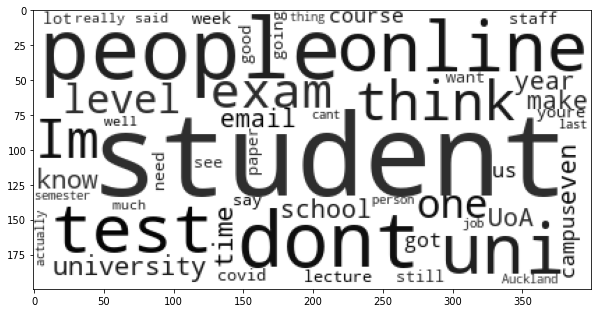

In [838]:
stp = STOPWORDS.copy()
"""Added inappropriate word into stopwords"""
stp.add("fucking")
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
wc.generate(comments_wc)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_colour_func, random_state=3))
plt.show()

Lemmatization

In [839]:
lemmatizer = nltk.WordNetLemmatizer()
comments.Reply = comments.Reply.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

In [840]:
comments.head()

,Reply,Time,Key
0,email straight pissed would like reinforce lis...,2020-09-14 12:38:11,0.0
1,stupid honestly take ONE asymptomatic student ...,2020-09-14 11:44:10,0.0
2,Sounds right tbh,2020-09-14 10:29:36,0.0
3,legit happened,2020-09-14 10:47:36,0.0
4,Im young healthy virus likely wont kill parent...,2020-09-14 12:58:34,0.0


# Sentiment Analysis

**Sentiment analysis using nltk Vader**

In [841]:
sid = SentimentIntensityAnalyzer()

In [842]:
comments_vader = comments

In [843]:
comments_vader[['neg','neu','pos','compound']] = comments_vader.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [844]:
comments_vader.head()

,Reply,Time,Key,neg,neu,pos,compound
0,email straight pissed would like reinforce lis...,2020-09-14 12:38:11,0.0,0.186,0.629,0.185,-0.2572
1,stupid honestly take ONE asymptomatic student ...,2020-09-14 11:44:10,0.0,0.236,0.556,0.208,-0.1027
2,Sounds right tbh,2020-09-14 10:29:36,0.0,0.000,1.000,0.000,0.0000
3,legit happened,2020-09-14 10:47:36,0.0,0.000,1.000,0.000,0.0000
4,Im young healthy virus likely wont kill parent...,2020-09-14 12:58:34,0.0,0.185,0.378,0.437,0.6529


Changing the float values of compound to "negative", "neutral" and "positive", hence, it's easier to read.

In [845]:
import numpy as np
comments_vader['compound'] = comments_vader.compound.apply(np.sign).replace({-1.0: 'negative', 1.0: 'positive', 0.0: 'neutral'})

In [846]:
comments_vader.head()

,Reply,Time,Key,neg,neu,pos,compound
0,email straight pissed would like reinforce lis...,2020-09-14 12:38:11,0.0,0.186,0.629,0.185,negative
1,stupid honestly take ONE asymptomatic student ...,2020-09-14 11:44:10,0.0,0.236,0.556,0.208,negative
2,Sounds right tbh,2020-09-14 10:29:36,0.0,0.000,1.000,0.000,neutral
3,legit happened,2020-09-14 10:47:36,0.0,0.000,1.000,0.000,neutral
4,Im young healthy virus likely wont kill parent...,2020-09-14 12:58:34,0.0,0.185,0.378,0.437,positive


**Sentiment Analysis using the trained model from Kaggle challenge**

In [847]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

In [848]:
import import_ipynb

In [849]:
%run realphase2.ipynb

In [850]:
test_comments = vectorizer.transform(comments.Reply)

In [851]:
predicted = nb.predict(test_comments)

In [852]:
comments['sentiment'] = predicted

In [853]:
comments.head()

,Reply,Time,Key,neg,neu,pos,compound,sentiment
0,email straight pissed would like reinforce lis...,2020-09-14 12:38:11,0.0,0.186,0.629,0.185,negative,neutral
1,stupid honestly take ONE asymptomatic student ...,2020-09-14 11:44:10,0.0,0.236,0.556,0.208,negative,negative
2,Sounds right tbh,2020-09-14 10:29:36,0.0,0.000,1.000,0.000,neutral,positive
3,legit happened,2020-09-14 10:47:36,0.0,0.000,1.000,0.000,neutral,neutral
4,Im young healthy virus likely wont kill parent...,2020-09-14 12:58:34,0.0,0.185,0.378,0.437,positive,negative


Dropping the results from using nltk Vader to make the data easier to compare

In [854]:
comments = comments.drop(['neg','neu','pos','compound'], axis = 1)

In [855]:
comments.head()

,Reply,Time,Key,sentiment
0,email straight pissed would like reinforce lis...,2020-09-14 12:38:11,0.0,neutral
1,stupid honestly take ONE asymptomatic student ...,2020-09-14 11:44:10,0.0,negative
2,Sounds right tbh,2020-09-14 10:29:36,0.0,positive
3,legit happened,2020-09-14 10:47:36,0.0,neutral
4,Im young healthy virus likely wont kill parent...,2020-09-14 12:58:34,0.0,negative


**Comparison between sentiment analysises using the trained model and nltk Vader**

In [856]:
comments_vader.compound.value_counts()

positive    251
negative    132
neutral     127
Name: compound, dtype: int64

In [857]:
comments.sentiment.value_counts()

neutral     378
negative     77
positive     55
Name: sentiment, dtype: int64

Getting the results to csv files

In [858]:
comments.to_csv('Comments_using_Kaggle_model.csv')

In [859]:
comments_vader.to_csv("Comments_using_Vader.csv")